In [49]:
import numpy as np
import sympy as sym
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker
import time

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from funcs import *

Define some functions for subtasks.

`elastic truss`

In [52]:
# force and torque calc for KT (dic) at dispalcement [u (in mm), phi (in rad)] (w)
# w/0 magnets

def get_ab(w, dic):
    n = dic['n']
    R0 = dic['R0'] 
    h0 = dic['h0']
    theta1 = dic['theta1']
    ks = dic['ks']
    u, phi = [w[0], w[1]]
    a = np.sqrt((h0+u)**2+4*R0**2*(np.sin(phi/2+theta1/2-np.pi/2/n))**2)    # mm
    b = np.sqrt((h0+u)**2+4*R0**2*(np.sin(phi/2+theta1/2+np.pi/2/n))**2)    # mm
    return a,b

def get_F_el(w, dic):
    R0 = dic['R0'] 
    h0 = dic['h0']
    theta1 = dic['theta1']
    ks = dic['ks']
    u, phi = [w[0], w[1]]
    a,b = get_ab(w, dic)
    a0,b0 = get_ab([0,0], dic)
    return -n*ks*(-u-h0)*(2-a0/a-b0/b) #in N

def get_T_el(w, dic):
    R0 = dic['R0'] 
    h0 = dic['h0']
    theta1 = dic['theta1']
    ks = dic['ks']
    u, phi = [w[0], w[1]]
    a,b = get_ab(w, dic)
    a0,b0 = get_ab([0,0], dic)
    temp = ((1-a0/a)*np.sin(phi+theta1-np.pi/n)+(1-b0/b)*np.sin(phi+theta1+np.pi/n))
    return n*ks*R0**2*0.001*temp #in N*m

`elastic truss` + `magnet`

In [53]:
# fvector F and T (with magnets)
def get_F_all(w, dic):
    u, phi = [w[0], w[1]]
    return (total_Zforce_parallel(dic, u, phi, 1, 1)*1000)[0][0] #in N

def get_T_all(w, dic):
    u, phi = [w[0], w[1]]
    return (total_torque_parallel(dic, u, phi, 1, 1)*1000)[0][0] #in N*m

`dynamic properties`

In [54]:
def calc_dynamic_property(dic, stable_pts, mass_per_bead):
    """ Use explicit 4th-order Runge Kutta time integration to calculate the dynamic response for a Kresling 
        truss subject to initial displacement, input force and/or torque.
    
    ARGUMENTS
        dic: a dictionary with info of the KT system, 
            (keys must include: n, R0, h0, theta1, points_ref, ks, mag_m, mag_arrange, connectivity).
        stable_pts: a list of stable states, e.g., [[u1, phi1], [u2, phi2]]. 
                    Each state is defined by deformation [u (in mm), phi (in rad)].
        mass_per_bead: mass per bead in the top polygon, float (in gram).

    RETUTN
        dynamic_pro: a dictionary saving dynamic properties,
                    including sub dictionaries for properties calculated from different stable states.
    """
    
    # system infor from dic
    points_ref = dic['points_ref']
    n = dic['n']
    R0 = dic['R0']
    h0 = dic['h0']
    theta1 = dic['theta1']
    ks = dic['ks']
    mag_m = dic['mag_m']
    mag_arrange = dic['mag_arrange']
    
    # mass and moment of inertia
    mass = n*mass_per_bead/1000 #in kg
    J = n*mass_per_bead/1000*(R0*0.001)**2 #in kg*m2
    
    Uz = sym.Symbol('Uz')
    Ang = sym.Symbol('Ang')
    # analytical equation for total potential energy
    total_sym = total_potential_sym(points_ref, n, R0, h0, theta1, ks, mag_m, mag_arrange, [Uz, Ang], norm=True)
    # force in N (ks*h0^2 is the factor used to normalize potention, Uz is in mm)
    force_sym = sym.diff(total_sym, Uz)*ks*h0**2 #in N
    dFdu = sym.diff(force_sym, Uz)*1e3 #N/m
    dFdphi = sym.diff(force_sym, Ang) #in N
    # torque in N*m (Ang in rad)
    torque_sym = sym.diff(total_sym, Ang)/1e3*ks*h0**2 #in N*m
    dTdu = sym.diff(torque_sym, Uz)*1e3 #in N
    dTdphi = sym.diff(torque_sym, Ang) #in N*m
    
    # create a dic for dynamic properties
    dynamic_pro = {}
    wn_set = []
    Tn_set = []
    shape_vec_set = []
    # loop through stable states
    jj = 1
    for stable_this in stable_pts:
        uz_this = stable_this[0] #in mm
        up_this = stable_this[1] #in rad

        # STIFFNESS matrix (uz_this in mm, up_this in rad)
        k11 = np.array(dFdu.evalf(subs={Uz:uz_this, Ang:up_this}), dtype='d') #in N/m
        k12 = np.array(dTdu.evalf(subs={Uz:uz_this, Ang:up_this}), dtype='d') #in N
        k21 = np.array(dFdphi.evalf(subs={Uz:uz_this, Ang:up_this}), dtype='d') #in N
        k22 = np.array(dTdphi.evalf(subs={Uz:uz_this, Ang:up_this}), dtype='d') #in N*m
        STIFF = np.array([[k11, k12],[k21, k22]])

        # MASS matrix
        MASS = np.array([[mass, 0],[0, J]]) #in kg and kg*m2

        # calc freq. and mode shape 
        wn2, shape_vec = np.linalg.eig(np.linalg.inv(MASS)@(STIFF))
        wn = np.sqrt(wn2)
        Tn = (2*np.pi)/np.sqrt(wn2)

        # output dic for dynamic properties
        mode_dic = {}
        mode_dic['mass'] = mass
        mode_dic['J'] = J
        mode_dic['pt'] = stable_this
        mode_dic['k'] = STIFF
        mode_dic['w1'] = wn[1]
        mode_dic['T1'] = Tn[1]
        mode_dic['f1'] = 1/Tn[1]
        mode_dic['modeshape1'] = shape_vec[:,1]
        mode_dic['w2'] = wn[0]
        mode_dic['T2'] = Tn[0]
        mode_dic['f2'] = 1/Tn[0]
        mode_dic['modeshape2'] = shape_vec[:,0]
        dynamic_pro[f'state{jj}'] = mode_dic.copy()
        jj += 1
        
    return dynamic_pro

- Explicit `4th-order Runge Kutta`

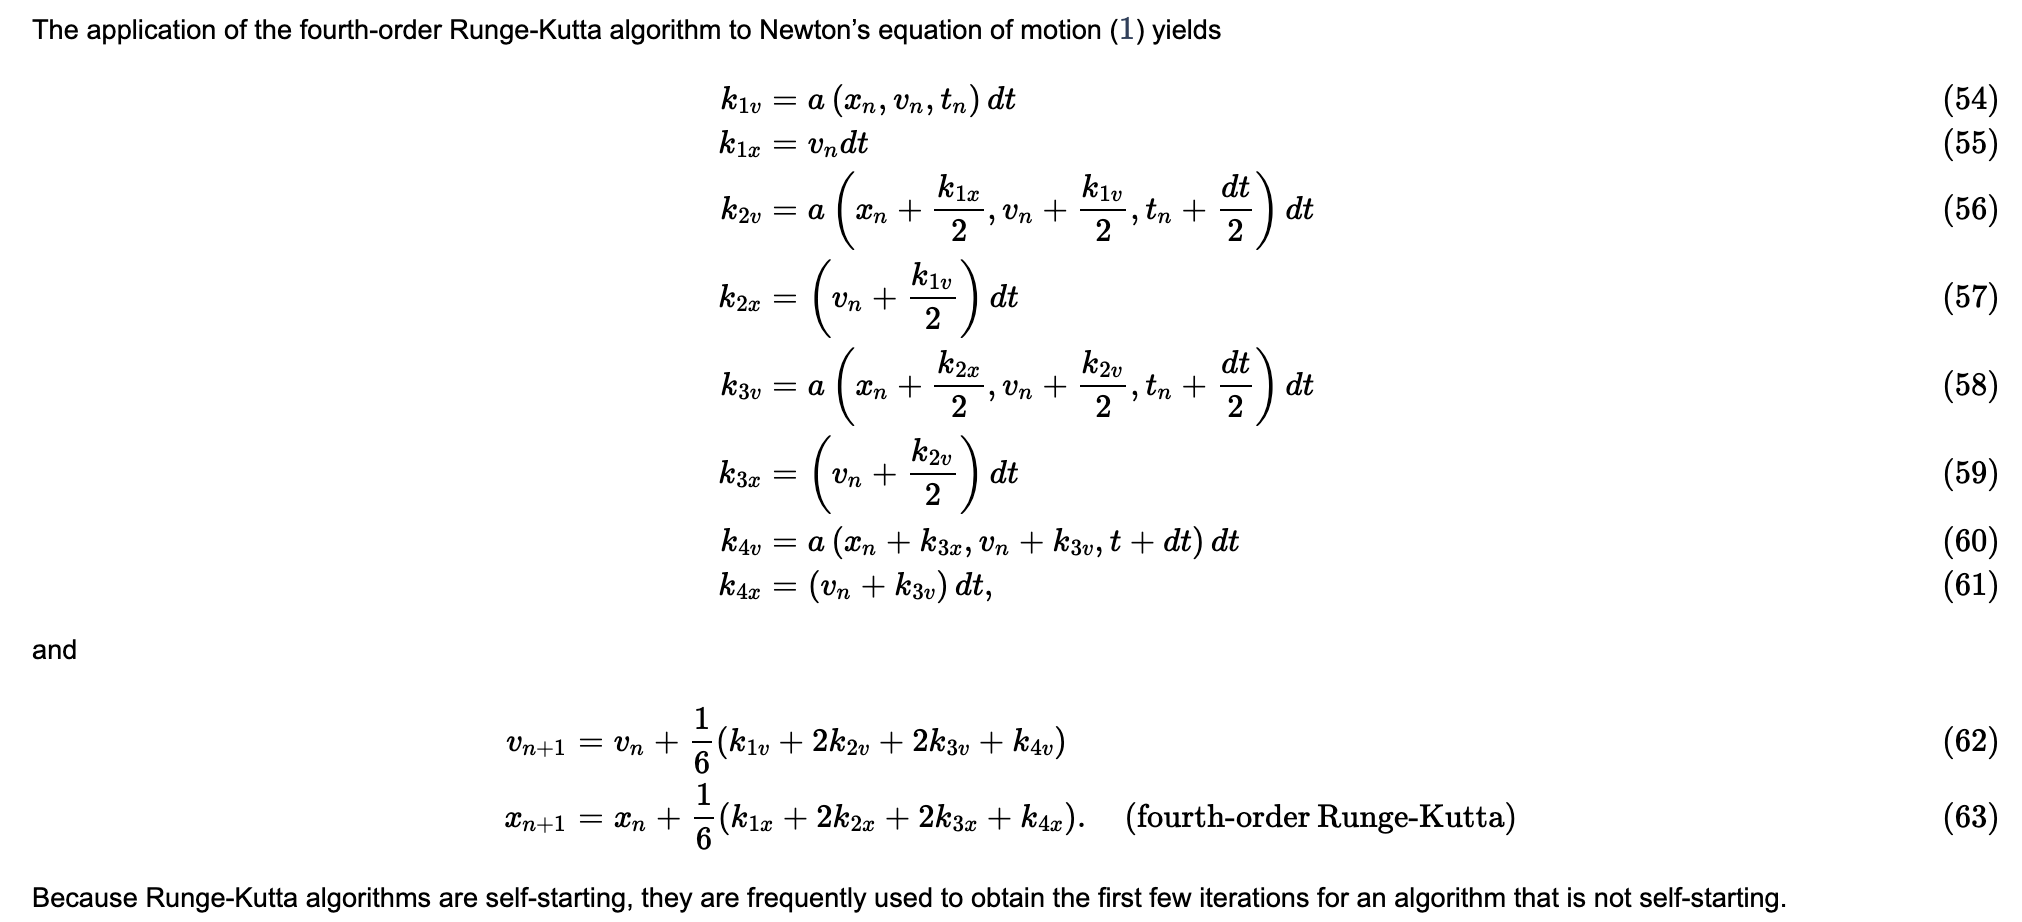

In [7]:
def dynamic_func_RK4(dic, mass, J, cz, cp, t, dt, uz0, up0, Fz_func, get_F, get_T, 
                         penk=5, penalty=False, outtime=0.05, beta=0.25, gamma=0.5):
    """ Use explicit 4th-order Runge Kutta time integration to calculate the dynamic response for a Kresling 
        truss subject to initial displacement, input force and/or torque.
    
    ARGUMENTS
        dic: a dictionary with info of the KT system, 
            (keys must include: n, R0, h0, theta1, points_ref, ks, mag_m, mag_arrange, connectivity).
        mass: system mass (top plate mass from n beads), float (in kg).
        J: system moment of inertia, float (in kg*m2).
        cz: damping in DOF u, float (in N*s/m). 
        cp: damping in DOF phi, float (in N*s/rad).
        t: length of integration, float (in sec).
        dt: integration time step, float (in sec).
        uz0: initial displacement u at t=0, float (in m).
        up0: initial rotation phi at t=0, float (in rad).
        Fz_input: input force time history, 1D array, [total number of steps,] (in N).
        Fp_input: input torque time history, 1D array, [total number of steps,] (in N*m).
        get_F: function to calculate force at displacement [u, phi], return force in N.
        get_T: function to calculate torque at displacement [u, phi], return torque in N*m.
        outtime: output disp. every 0.05s

    RETUTN
        uz: vertical displacement time history, 1D array, [total number of steps,] (in m).
        up: rotation angle time history, 1D array, [total number of steps,] (in rad).
        vz: vertical velocity time history, 1D array, [total number of steps,] (in m/s).
        vp: rotation angle velocity time history, 1D array, [total number of steps,] (in rad/s).
        az: vertical acceleration time history, 1D array, [total number of steps,] (in m/s2).
        ap: rotation angle acceleration time history, 1D array, [total number of steps,] (in rad/s2).
    """
    n = dic['n']
    R0 = dic['R0'] 
    h0 = dic['h0']
    theta1 = dic['theta1']
    ks = dic['ks']
    nstep = int(1+t/dt)
    
    # initialize array for output
    vz_out = [0]
    vp_out = [0]
    uz_out = [uz0]
    up_out = [up0]
    az_out = [0]
    ap_out = [0]
    
    # initial condition (assume no initial velocity)
    vz_old = 0
    vp_old = 0
    uz_old = uz0
    up_old = up0
    
    outfreq = int(outtime/dt)
    
    # time integration
    for i in range(nstep-1):
        
        Fz = Fz_func(i) - penk*(uz_old*1000+0.8*h0<=0)*penalty*(uz_old*1000+0.8*h0)
        Fp = 0

        # substep1
        az1 = (Fz - get_F([uz_old*1000, up_old], dic) - cz*vz_old)/mass
        ap1 = (Fp - get_T([uz_old*1000, up_old], dic) - cp*vp_old)/J  
        kvz1 = az1*dt
        kvp1 = ap1*dt
        kuz1 = vz_old*dt
        kup1 = vp_old*dt
        # substep2
        az2 = (Fz - get_F([(uz_old+kuz1/2)*1000, (up_old+kup1/2)], dic) - cz*(vz_old+kvz1/2))/mass   
        ap2 = (Fp - get_T([(uz_old+kuz1/2)*1000, (up_old+kup1/2)], dic) - cp*(vp_old+kvp1/2))/J    
        kvz2 = az2*dt
        kvp2 = ap2*dt
        kuz2 = (vz_old+kvz1/2)*dt
        kup2 = (vp_old+kvp1/2)*dt
        # substep3
        az3 = (Fz - get_F([(uz_old+kuz2/2)*1000, (up_old+kup2/2)], dic) - cz*(vz_old+kvz2/2))/mass    
        ap3 = (Fp - get_T([(uz_old+kuz2/2)*1000, (up_old+kup2/2)], dic) - cp*(vp_old+kvp2/2))/J   
        kvz3 = az3*dt
        kvp3 = ap3*dt
        kuz3 = (vz_old+kvz2/2)*dt
        kup3 = (vp_old+kvp2/2)*dt
        # substep4
        az4 = (Fz - get_F([(uz_old+kuz3)*1000, (up_old+kup3)], dic) - cz*(vz_old+kvz3))/mass     
        ap4 = (Fp - get_T([(uz_old+kuz3)*1000, (up_old+kup3)], dic) - cp*(vp_old+kvp3))/J    
        kvz4 = az4*dt
        kvp4 = ap4*dt
        kuz4 = (vz_old+kvz3)*dt
        kup4 = (vp_old+kvp3)*dt

        # update disp. vel. and acc.
        uz_new = uz_old + 1/6.0*(kuz1+2*kuz2+2*kuz3+kuz4)  #in m
        vz_new = vz_old + 1/6.0*(kvz1+2*kvz2+2*kvz3+kvz4) #in m/s
        az_new = (vz_new-vz_old)/dt #in m/s2
        up_new = up_old + 1/6.0*(kup1+2*kup2+2*kup3+kup4) #in rad
        vp_new = vp_old + 1/6.0*(kvp1+2*kvp2+2*kvp3+kvp4) #in rad/s
        ap_new = (vp_new-vp_old)/dt #in rad/s2

        # save dynamically
        if (i+1)%outfreq == 0:
            uz_out.append(uz_new)
            vz_out.append(vz_new)
            az_out.append(az_new)
            up_out.append(up_new)
            vp_out.append(vp_new)
            ap_out.append(ap_new)    
        
        # break if top plate touches the bottom plate
        if (not penalty) and (uz_new*1000+h0<0):
            break
            
        # update old values
        uz_old = uz_new
        vz_old = vz_new
        az_old = az_new
        up_old = up_new
        vp_old = vp_new
        ap_old = ap_new
           
    return np.array(uz_out), np.array(up_out), np.array(vz_out), np.array(vp_out), np.array(az_out), np.array(ap_out)

https://www.compadre.org/PICUP/resources/Numerical-Integration/

- Explicit `Velocity Verlet`

<div>
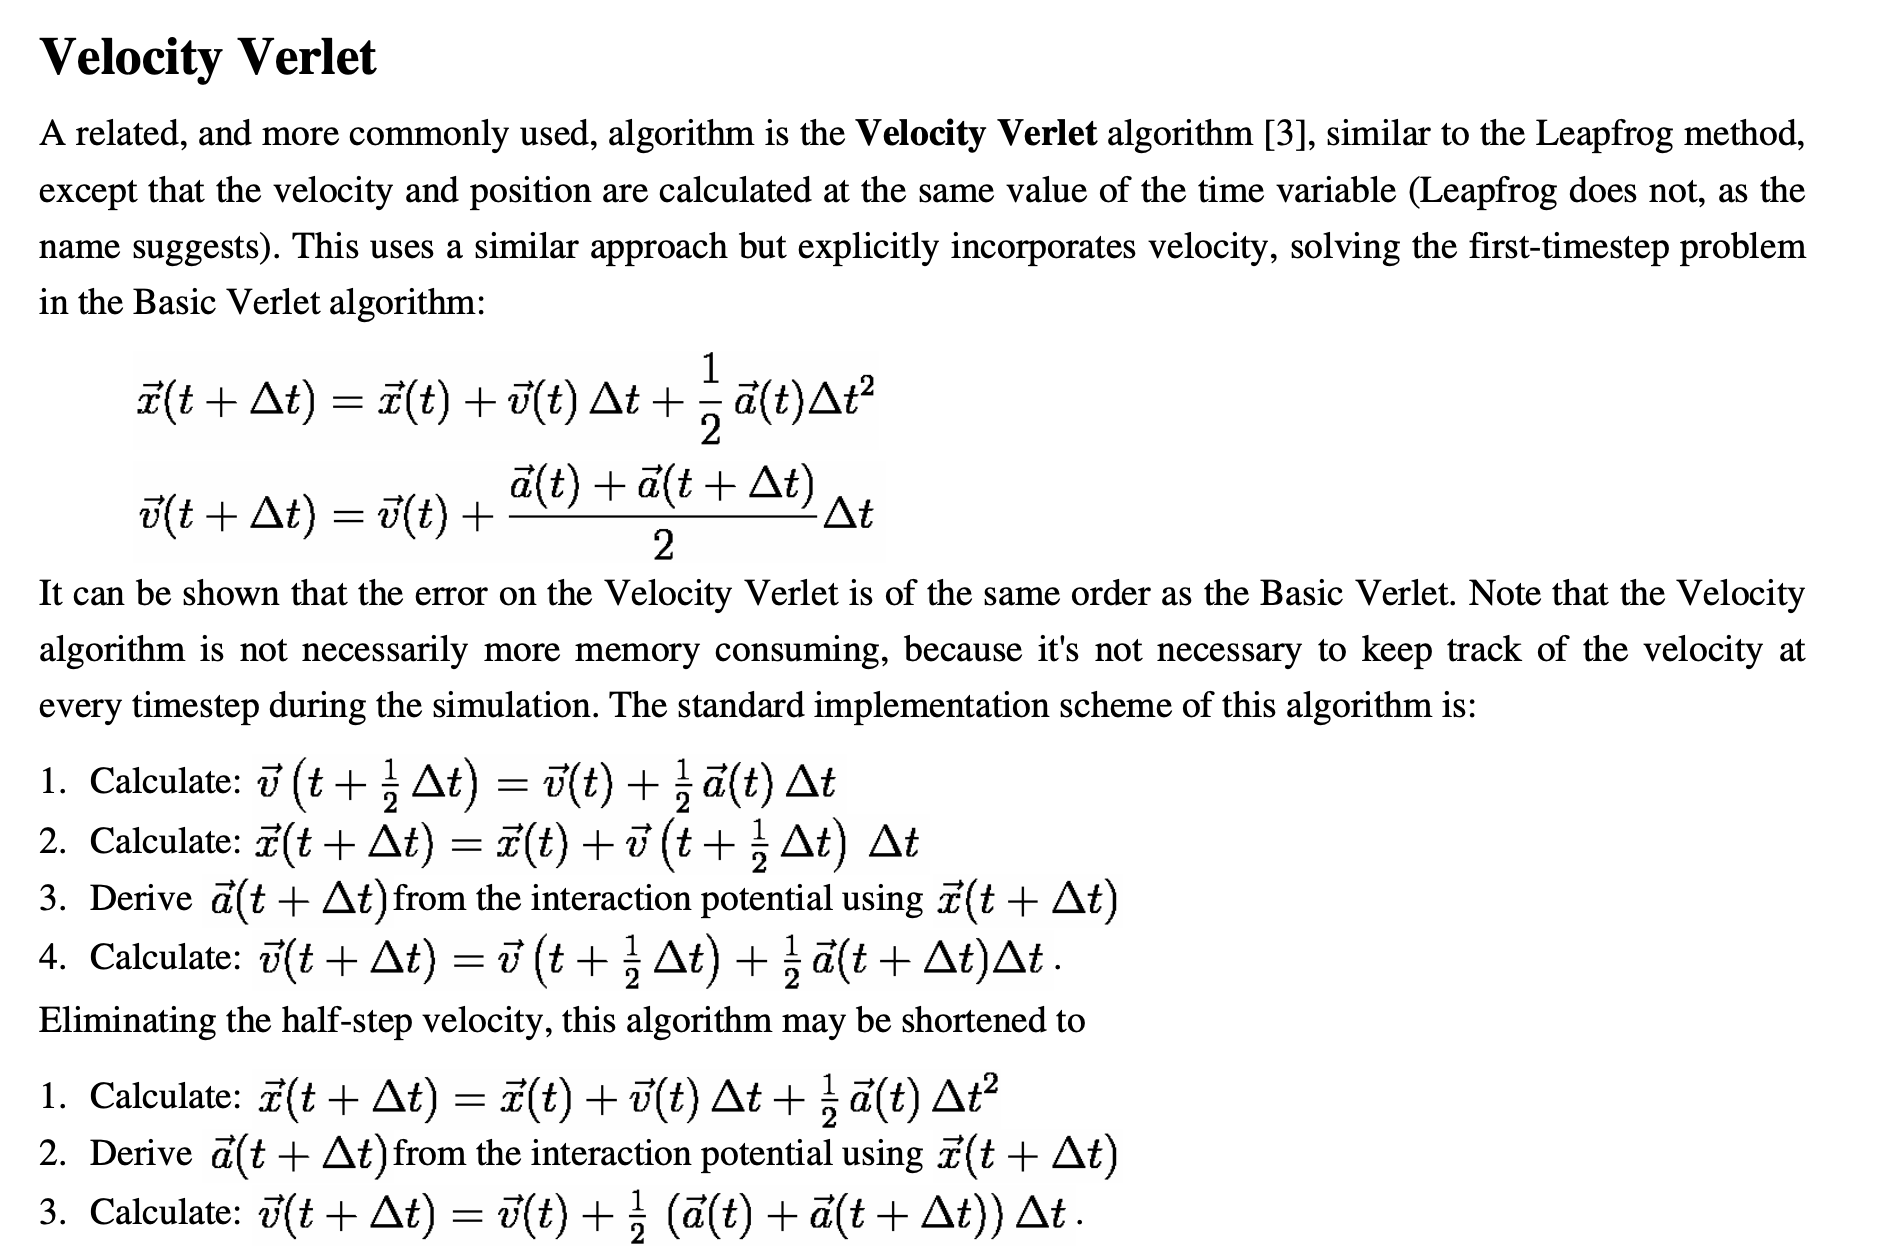
</div>

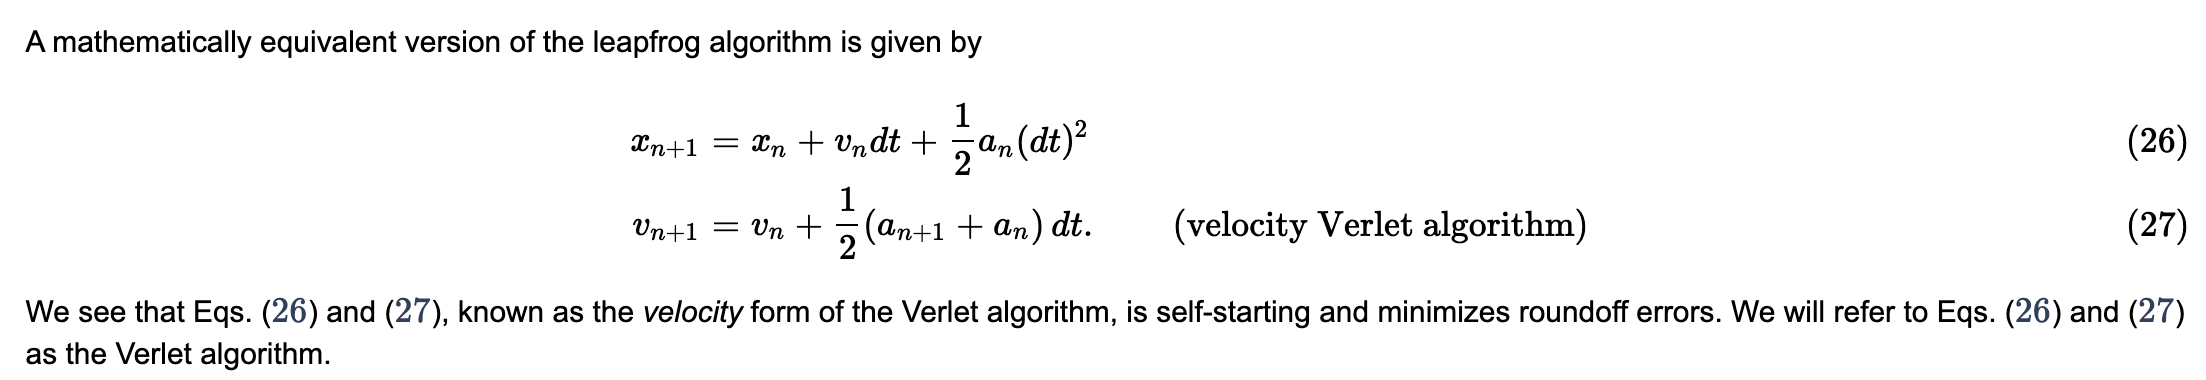

Implement here

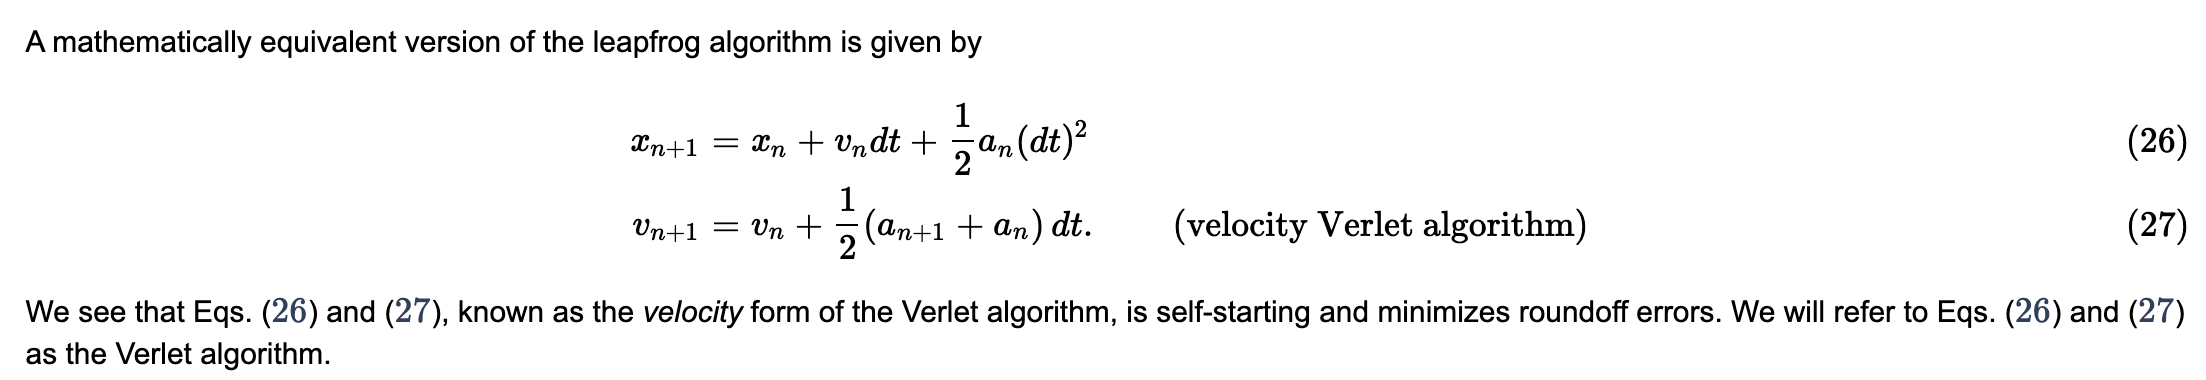

https://www.compadre.org/PICUP/resources/Numerical-Integration/

In [8]:
def dynamic_func_VV(dic, mass, J, cz, cp, t, dt, uz0, up0, Fz_func, get_F, get_T, 
                         penk=5, penalty=False, outtime=0.05, beta=0.25, gamma=0.5):
    """ Use explicit 4th-order Runge Kutta time integration to calculate the dynamic response for a Kresling 
        truss subject to initial displacement, input force and/or torque.
    
    ARGUMENTS
        dic: a dictionary with info of the KT system, 
            (keys must include: n, R0, h0, theta1, points_ref, ks, mag_m, mag_arrange, connectivity).
        mass: system mass (top plate mass from n beads), float (in kg).
        J: system moment of inertia, float (in kg*m2).
        cz: damping in DOF u, float (in N*s/m). 
        cp: damping in DOF phi, float (in N*s/rad).
        t: length of integration, float (in sec).
        dt: integration time step, float (in sec).
        uz0: initial displacement u at t=0, float (in m).
        up0: initial rotation phi at t=0, float (in rad).
        Fz_input: input force time history, 1D array, [total number of steps,] (in N).
        Fp_input: input torque time history, 1D array, [total number of steps,] (in N*m).
        get_F: function to calculate force at displacement [u, phi], return force in N.
        get_T: function to calculate torque at displacement [u, phi], return torque in N*m.
        outtime: output disp. every 0.05s

    RETUTN
        uz: vertical displacement time history, 1D array, [total number of steps,] (in m).
        up: rotation angle time history, 1D array, [total number of steps,] (in rad).
        vz: vertical velocity time history, 1D array, [total number of steps,] (in m/s).
        vp: rotation angle velocity time history, 1D array, [total number of steps,] (in rad/s).
        az: vertical acceleration time history, 1D array, [total number of steps,] (in m/s2).
        ap: rotation angle acceleration time history, 1D array, [total number of steps,] (in rad/s2).
    """
    n = dic['n']
    R0 = dic['R0'] 
    h0 = dic['h0']
    theta1 = dic['theta1']
    ks = dic['ks']
    nstep = int(1+t/dt)
    
    # initialize array for output
    vz_out = [0]
    vp_out = [0]
    uz_out = [uz0]
    up_out = [up0]
    az_out = [0]
    ap_out = [0]
    
    # initial condition (assume no initial velocity)
    vz_old = 0
    vp_old = 0
    uz_old = uz0
    up_old = up0
    
    outfreq = int(outtime/dt)
    # time integration
    for i in range(nstep-1):
        
        Fz = Fz_func(i) - penk*(uz_old*1000+0.8*h0<=0)*penalty*(uz_old*1000+0.8*h0)
        Fp = 0
        
        az_old = (Fz - get_F([uz_old*1000, up_old], dic) - cz*vz_old)/mass     #in m/s2
        ap_old = (Fp - get_T([uz_old*1000, up_old], dic) - cp*vp_old)/J     #in rad/s2
        uz_new = uz_old + vz_old*dt + 0.5*az_old*dt**2
        up_new = up_old + vp_old*dt + 0.5*ap_old*dt**2
        # tricky damping cz and zp (should use vz_new, vp_new to update az, ap, but we do not have them)
        az_new = (Fz - get_F([uz_new*1000, up_new], dic) - cz*vz_old)/mass     #in m/s2
        ap_new = (Fp - get_T([uz_new*1000, up_new], dic) - cp*vp_old)/J     #in rad/s2
        vz_new = vz_old + 0.5*(az_new+az_old)*dt
        vp_new = vp_old + 0.5*(ap_new+ap_old)*dt

        # save dynamically
        if (i+1)%outfreq == 0:
            uz_out.append(uz_new)
            vz_out.append(vz_new)
            az_out.append(az_new)
            up_out.append(up_new)
            vp_out.append(vp_new)
            ap_out.append(ap_new)    
        
        # break if top plate touches the bottom plate
        if (not penalty) and (uz_new*1000+h0<0):
            break
            
        # update old values
        uz_old = uz_new
        vz_old = vz_new
        az_old = az_new
        up_old = up_new
        vp_old = vp_new
        ap_old = ap_new
           
    return np.array(uz_out), np.array(up_out), np.array(vz_out), np.array(vp_out), np.array(az_out), np.array(ap_out)

- Implicit `Newmark`

<div>
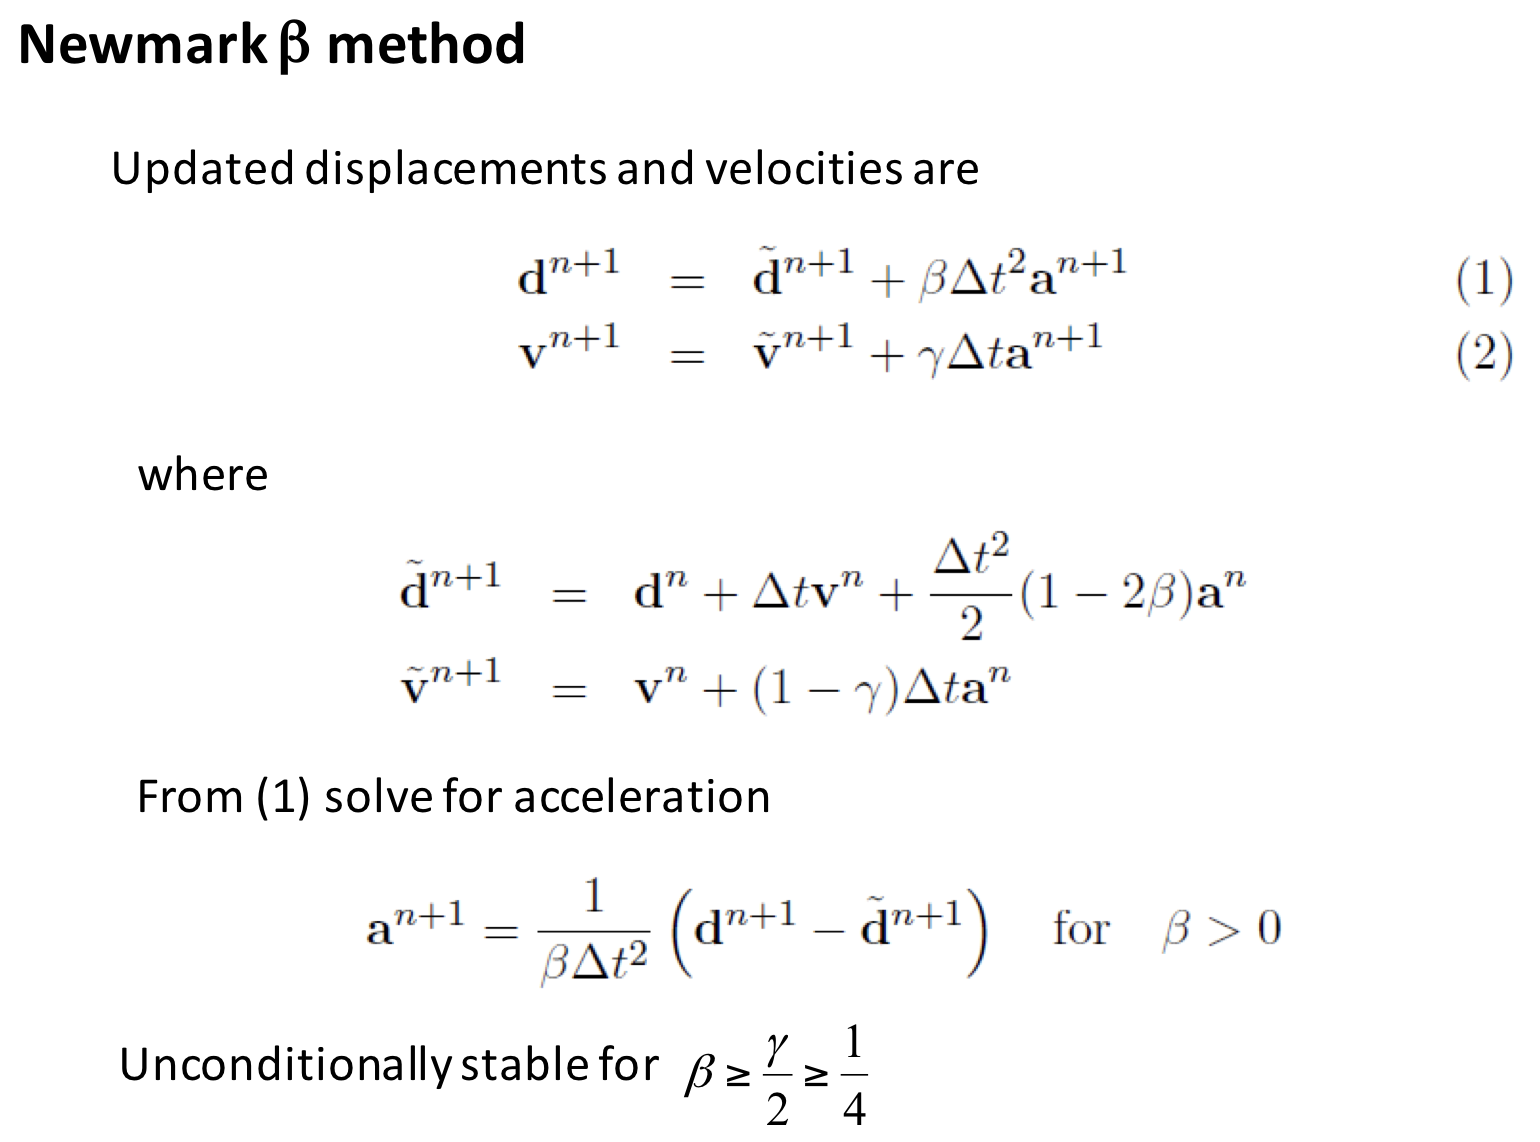
</div>

<div>
<img src="attachment:IMG_6531.PNG" width="500"/>
</div>

<div>
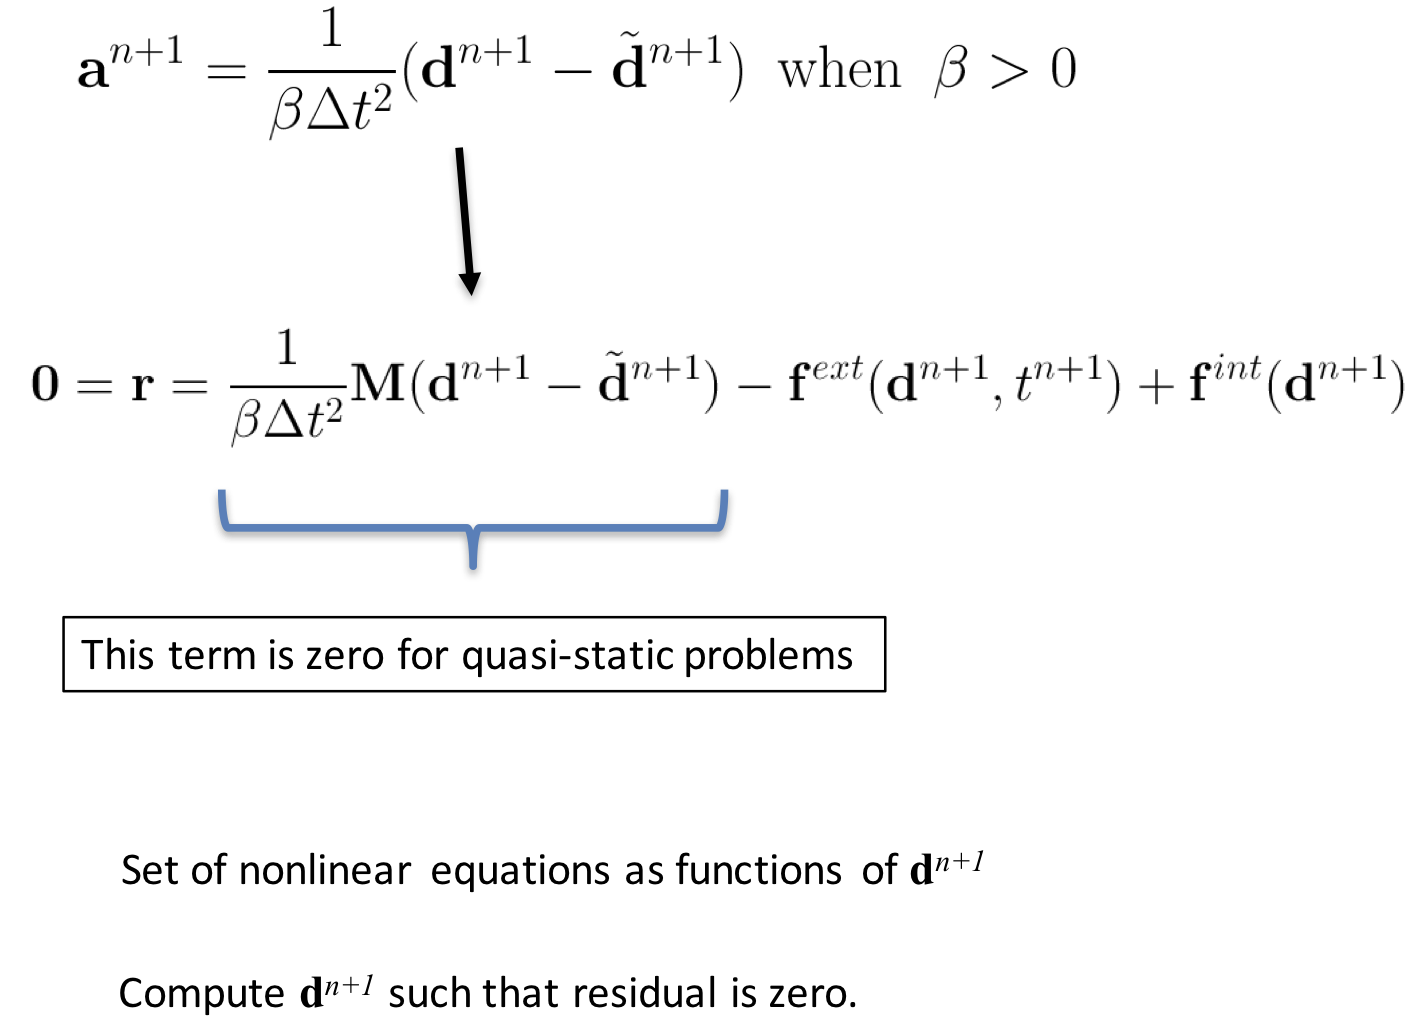
<div>

In [9]:
def dynamic_func_newmark(dic, mass, J, cz, cp, t, dt, uz0, up0, Fz_func, get_F, get_T, 
                         penk=5, penalty=False, outtime=0.05, beta=0.25, gamma=0.5):
    """ Use explicit 4th-order Runge Kutta time integration to calculate the dynamic response for a Kresling 
        truss subject to initial displacement, input force and/or torque.
    
    ARGUMENTS
        dic: a dictionary with info of the KT system, 
            (keys must include: n, R0, h0, theta1, points_ref, ks, mag_m, mag_arrange, connectivity).
        mass: system mass (top plate mass from n beads), float (in kg).
        J: system moment of inertia, float (in kg*m2).
        cz: damping in DOF u, float (in N*s/m). 
        cp: damping in DOF phi, float (in N*s/rad).
        t: length of integration, float (in sec).
        dt: integration time step, float (in sec).
        uz0: initial displacement u at t=0, float (in m).
        up0: initial rotation phi at t=0, float (in rad).
        get_F: function to calculate force at displacement [u, phi], return force in N.
        get_T: function to calculate torque at displacement [u, phi], return torque in N*m.
        outtime: output disp. every 0.05s

    RETUTN
        uz: vertical displacement time history, 1D array, [total number of steps,] (in m).
        up: rotation angle time history, 1D array, [total number of steps,] (in rad).
        vz: vertical velocity time history, 1D array, [total number of steps,] (in m/s).
        vp: rotation angle velocity time history, 1D array, [total number of steps,] (in rad/s).
        az: vertical acceleration time history, 1D array, [total number of steps,] (in m/s2).
        ap: rotation angle acceleration time history, 1D array, [total number of steps,] (in rad/s2).
    """
    n = dic['n']
    R0 = dic['R0'] 
    h0 = dic['h0']
    theta1 = dic['theta1']
    ks = dic['ks']
    nstep = int(1+t/dt)
    
    # initialize array for output
    vz_out = [0]
    vp_out = [0]
    uz_out = [uz0]
    up_out = [up0]
    az_out = [0]
    ap_out = [0]
    
    # initial condition (assume no initial velocity)
    vz_old = 0
    vp_old = 0
    uz_old = uz0
    up_old = up0
    az_old = 0
    ap_old = 0
    
    outfreq = int(outtime/dt)
    # time integration
    for i in range(nstep-1):
        
        Fz = Fz_func(i) - penk*(uz_old*1000+0.8*h0<=0)*penalty*(uz_old*1000+0.8*h0)
        Fp = 0
        
        uz_temp = uz_old + dt*vz_old + dt**2/2*(1-2*beta)*az_old
        up_temp = up_old + dt*vp_old + dt**2/2*(1-2*beta)*ap_old
        
        def residual(x):
            az_new = 1/(beta*dt**2)*(x[0] - uz_temp)     #in m/s2
            ap_new = 1/(beta*dt**2)*(x[1] - up_temp)     #in rad/s2
            vz_new = vz_old + (1-gamma)*dt*az_old + gamma*dt*az_new
            vp_new = vp_old + (1-gamma)*dt*ap_old + gamma*dt*ap_new
            return [az_new*mass + get_F([x[0]*1000, x[1]], dic) + cz*vz_new - 
                    (Fz_func(i+1) - penk*(x[0]*1000+0.8*h0<=0)*penalty*(x[0]*1000+0.8*h0)),
                   ap_new*J + get_T([x[0]*1000, x[1]], dic) + cp*vp_new - 0]

        sol = optimize.root(residual, [uz_old, up_old], method='hybr')
        if not sol.success:
            print(f"Failed to find r=0 pts at step {i}.")
            
        uz_new, up_new = sol.x
        
        az_new = 1/(beta*dt**2)*(uz_new - uz_temp)     #in m/s2
        ap_new = 1/(beta*dt**2)*(up_new - up_temp)     #in rad/s2
        vz_new = vz_old + (1-gamma)*dt*az_old + gamma*dt*az_new
        vp_new = vp_old + (1-gamma)*dt*ap_old + gamma*dt*ap_new

        # save dynamically
        if (i+1)%outfreq == 0:
            uz_out.append(uz_new)
            vz_out.append(vz_new)
            az_out.append(az_new)
            up_out.append(up_new)
            vp_out.append(vp_new)
            ap_out.append(ap_new)    
        
        # break if top plate touches the bottom plate
        if (not penalty) and (uz_new*1000+h0<0):
            break
            
        # update old values
        uz_old = uz_new
        vz_old = vz_new
        az_old = az_new
        up_old = up_new
        vp_old = vp_new
        ap_old = ap_new
           
    return np.array(uz_out), np.array(up_out), np.array(vz_out), np.array(vp_out), np.array(az_out), np.array(ap_out)

### Put everything together.

In [10]:
def dynamic_response_harm(static_dic, dynamic_dic, t, dt, cz, cp, integral_func, get_F, get_T,
                    uz0, up0, wb_z, ab_z, penk=5, penalty=False, outtime=0.05, beta=0.25, gamma=0.5):
    # M
    mm = dynamic_dic['mass']
    JJ = dynamic_dic['J']

#     # C
#     cz = dampa0*mm
#     cp = dampa0*JJ
    
    def Fz_harm_this(i):
        return mm*ab_z*np.cos(wb_z*i*dt)
    
    # integration
    uz, up, vz, vp, az, ap = integral_func(dic, mm, JJ, cz, cp, t, dt, 
                                           uz0, up0, Fz_harm_this, get_F, get_T, penk=penk, 
                                           penalty=penalty, outtime=outtime, beta=beta, gamma=gamma)

    output_dic = {}
    output_dic['t'] = t
    output_dic['dt'] = dt
    output_dic['nstep'] = int(1+t/dt)
    output_dic['dynamic_dic'] = dynamic_dic
    output_dic['input_dic'] = {'wb_z': wb_z, 'ab_z':ab_z}
    output_dic['history'] = [uz, up, vz, vp, az, ap]

    return output_dic

In [11]:
def dynamic_response_step(static_dic, dynamic_dic, t, dt, cz, cp, integral_func, get_F, get_T,
                    uz0, up0, ab_z, penk=5, penalty=False, outtime=0.05, beta=0.25, gamma=0.5):
    # M
    mm = dynamic_dic['mass']
    JJ = dynamic_dic['J']

#     # C
#     cz = dampa0*mm
#     cp = dampa0*JJ
    
    def Fz_const_this(i):
        return ab_z
    
    # integration
    uz, up, vz, vp, az, ap = integral_func(dic, mm, JJ, cz, cp, t, dt, 
                                           uz0, up0, Fz_const_this, get_F, get_T, penk=penk, 
                                           penalty=penalty, outtime=outtime, beta=beta, gamma=gamma)

    output_dic = {}
    output_dic['t'] = t
    output_dic['dt'] = dt
    output_dic['nstep'] = int(1+t/dt)
    output_dic['dynamic_dic'] = dynamic_dic
    output_dic['input_dic'] = {'F_z':ab_z}
    output_dic['history'] = [uz, up, vz, vp, az, ap]

    return output_dic

### Initialization

In [12]:
factor = 250
scaleup = 1.0
fscale = 1.0

n = 8       # n-sided polygons
R0 = 90*scaleup     # in mm

# truss
ks = 0.02656
# magnet
Kd = 0.8*1e6

Rm = 5    # in mm
tm = 10   # in mm
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)
mag_m = mag_m*(scaleup**2.5)*fscale**0.5    # magnet moment (A*m2)
tempa = np.repeat(np.array([[1],[-1]]), n//2 ,axis=1).T.flatten()
tempb = np.repeat(np.array([[-1],[1]]), n//2 ,axis=1).T.flatten()
mag_arrange = np.hstack([tempa, tempb])
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T

In [15]:
# initial configuration [h0 (in mm), theta (in rad)]
w0 = [107.794937,  29.655172/180*np.pi]

In [16]:
dic = create_KTgeometry(n, R0, w0[0], w0[1], ks, mag_m, mag_arrange)

### Properties for stable states

In [18]:
# stable states defined by deformation in u (in mm) and phi (in rad)
stable1 = [1.20394e-02,  7.34033e-02/180*np.pi]
stable2 = [-7.34057e+01,  5.07793e+01/180*np.pi]
stable3 = [-84.61974430649448, -1.24486e+02/180*np.pi]

In [19]:
# calculate dynamic properties at stable states 
mass_per_bead = 30
dynamic_property = calc_dynamic_property(dic, [stable1, stable2, stable3], mass_per_bead)

In [20]:
dynamic_property['state1']

{'mass': 0.24,
 'J': 0.0019439999999999998,
 'pt': [0.0120394, 0.0012811292668291538],
 'k': array([[349.05621957,  10.21412825],
        [ 10.21412825,   0.50053251]]),
 'w1': 9.654016522528805,
 'T1': 0.6508363946257001,
 'f1': 1.5364844502512893,
 'modeshape1': array([-0.03125041,  0.99951159]),
 'w2': 40.23277830096182,
 'T2': 0.15617080332305508,
 'f2': 6.40324554091842,
 'modeshape2': array([0.25079051, 0.96804138])}

In [21]:
dynamic_property['state2']

{'mass': 0.24,
 'J': 0.0019439999999999998,
 'pt': [-73.4057, 0.8862659768579566],
 'k': array([[19.83841101,  1.41809176],
        [ 1.41809176,  1.38625077]]),
 'w1': 26.830138592336585,
 'T1': 0.23418385579917333,
 'f1': 4.270149180810995,
 'modeshape1': array([-0.00927259, -0.99995701]),
 'w2': 8.711811923445374,
 'T2': 0.7212260046925684,
 'f2': 1.3865279309032437,
 'modeshape2': array([-0.65786648,  0.75313458])}

In [22]:
dynamic_property['state3']

{'mass': 0.24,
 'J': 0.0019439999999999998,
 'pt': [-84.61974430649448, -2.172690572637661],
 'k': array([[121.89718032,  -2.48424503],
        [ -2.48424503,   0.29153311]]),
 'w1': 10.779451071744772,
 'T1': 0.5828854609906017,
 'f1': 1.7156029218854092,
 'modeshape1': array([0.0264161 , 0.99965103]),
 'w2': 23.273889731904973,
 'T2': 0.2699671339667083,
 'f2': 3.704154595808383,
 'modeshape2': array([ 0.29306539, -0.9560924 ])}

- 1st stable state

<IPython.core.display.Javascript object>


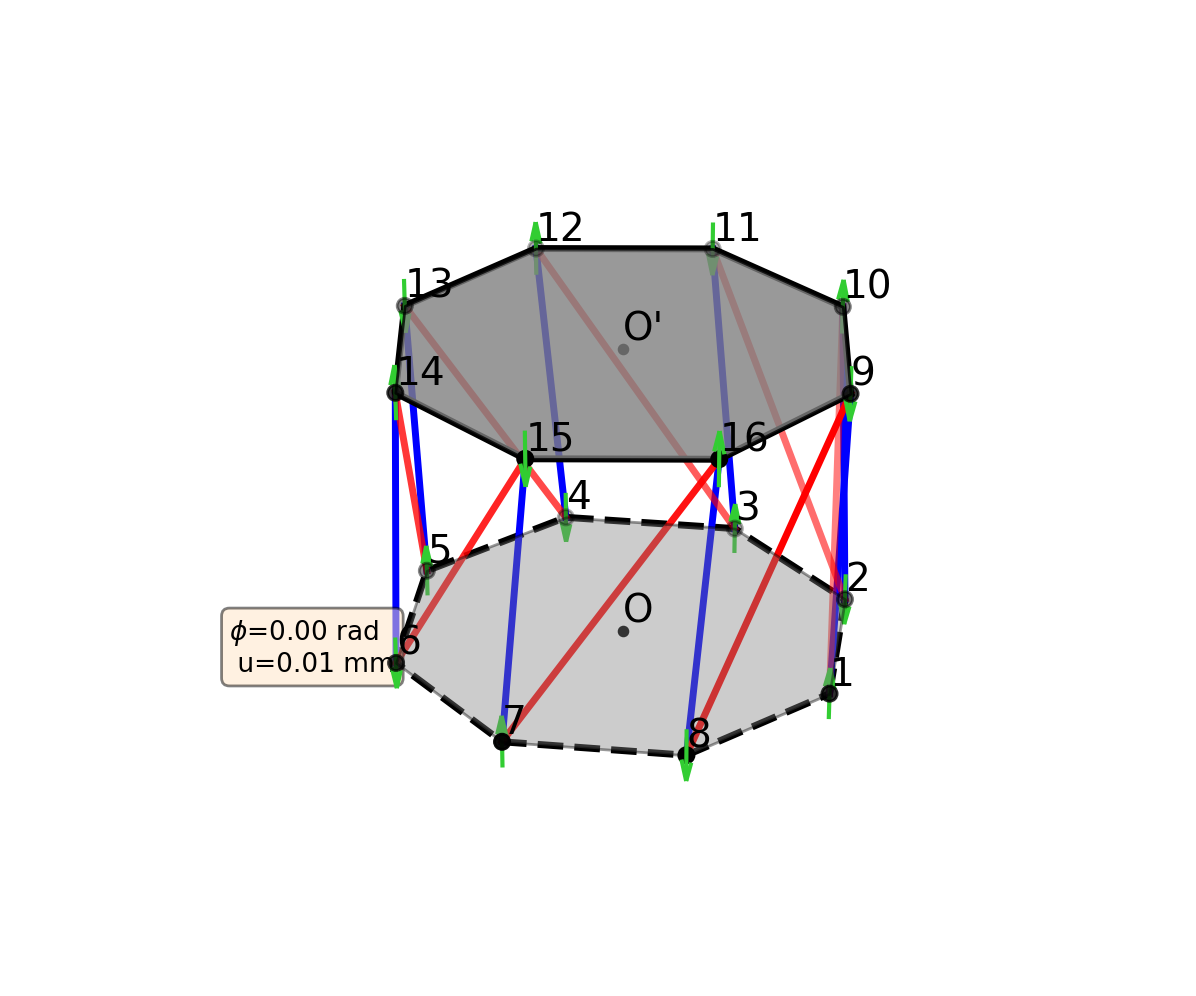

In [23]:
plot_TCO(dic, stable1, in_F=False, disp=True, 
             gap=5, arrow_coeff=20, grid=False, axis=False, tick=False)

- 2nd stable state

<IPython.core.display.Javascript object>


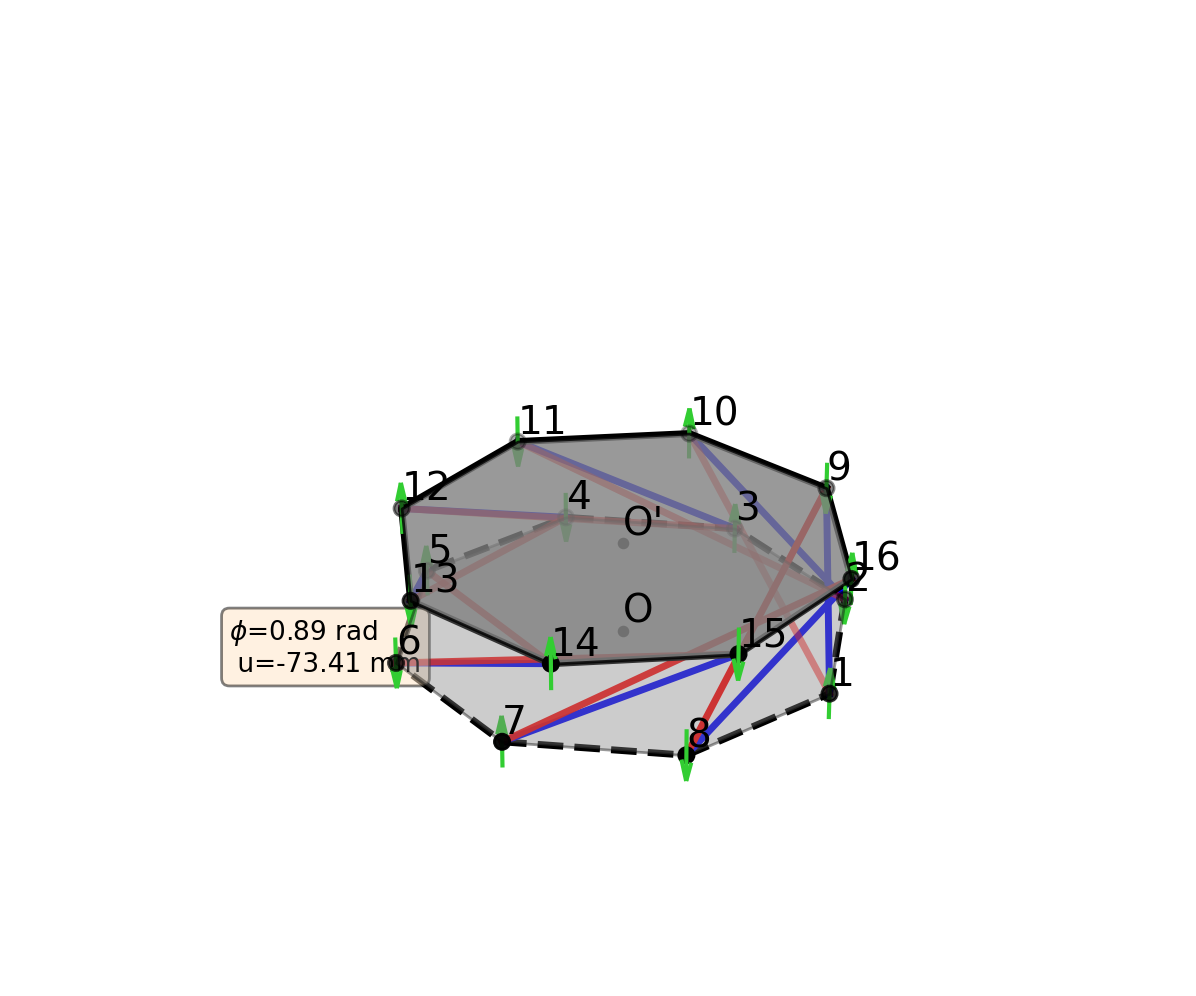

In [24]:
plot_TCO(dic, stable2, in_F=False, disp=True, 
             gap=5, arrow_coeff=20, grid=False, axis=False, tick=False)

- 3rd stable state

<IPython.core.display.Javascript object>


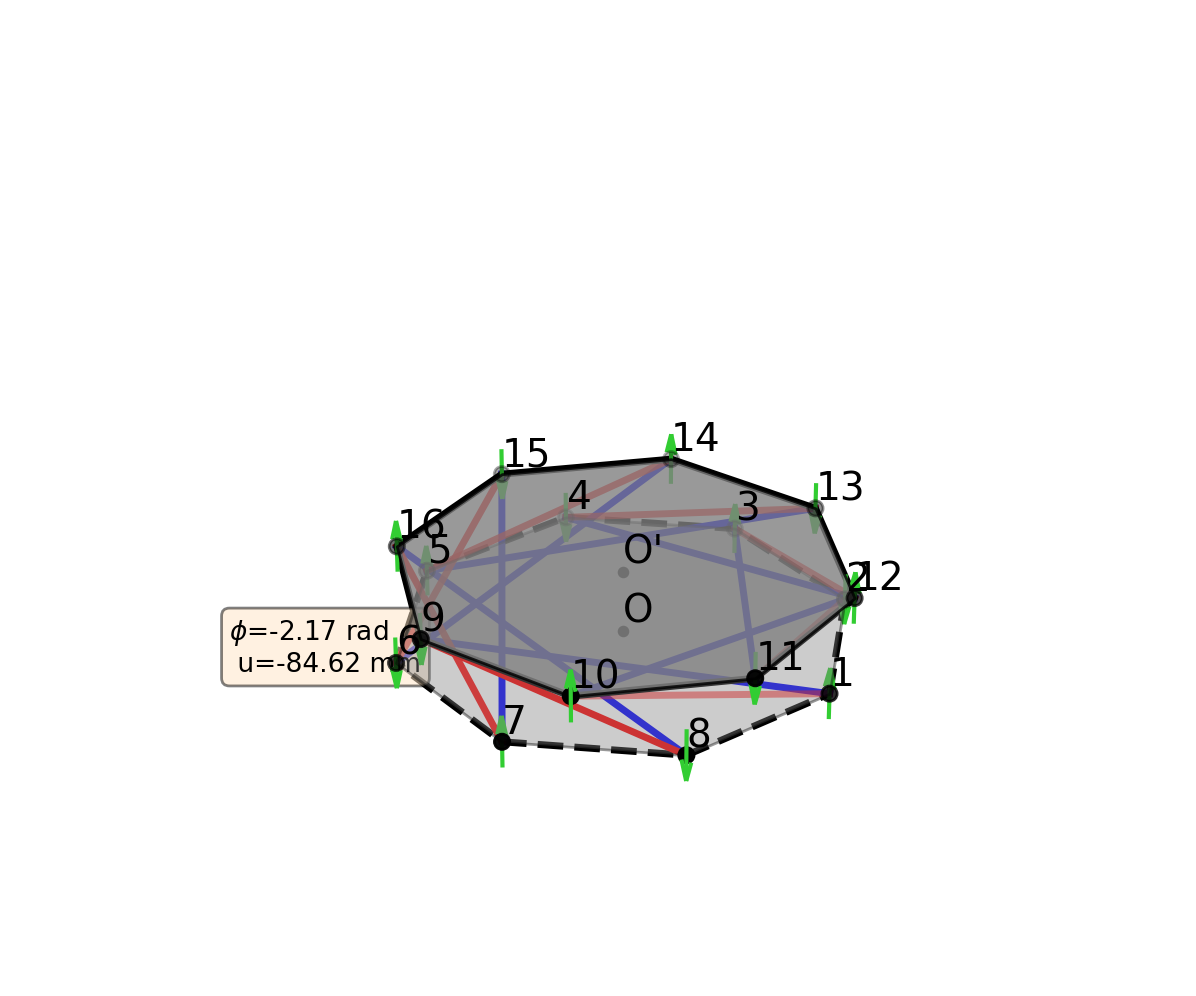

In [25]:
plot_TCO(dic, stable3, in_F=False, disp=True, 
             gap=5, arrow_coeff=20, grid=False, axis=False, tick=False)

### Mass-proportional damping

1. Use mass-proportional damping such that the damping ratio for the first mode is 0.05.
<br> $\zeta$<1 underdamped, $\zeta$=1 crtical damped (does not oscillate), $\zeta$>1 overdamped (does not oscillate, decays with slower rate) 
2. The dynamic properties calculated from the stable state 1 are used. 

In [26]:
get_F_all(dynamic_property['state1']['pt'], dic)

8.919566820596272e-08

In [27]:
get_T_all(dynamic_property['state1']['pt'], dic)

-1.5773465780230117e-07

In [55]:
# a0 in mass-proportional damping, a0 = c/m = 2*zeta*wn
dampa0 = 2*0.05*dynamic_property['state1']['w1']
dampa0

0.9654016522528805

In [30]:
# zeta_mode_1 = a0/(2*w1)
zeta_m1 = dampa0/2/dynamic_property['state1']['w1'] 
zeta_m1

0.05

In [31]:
# zeta_mode_2 = a0/(2*w2)
zeta_m2 = dampa0/2/dynamic_property['state1']['w2'] 
zeta_m2

0.011997700544456326

Thus

In [56]:
# c = 2*m*wn*zeta (first mode 5% damping), Fdamp_u = c*vz
cu = 2*dynamic_property['state1']['mass']*dynamic_property['state1']['w1']*zeta_m1
cu

0.2316963965406913

In [57]:
# c = 2*m*wn*zeta (first mode 5% damping), Fdamp_u = c*vz
cphi = 2*dynamic_property['state1']['J']*dynamic_property['state1']['w2']*zeta_m2
cphi

0.0018767408119795994

### Assign values

In [58]:
dampcu = cu

In [59]:
dampcphi = cphi

### Time integration by the explicit 4th-order Runge Kutta

In [60]:
def tell_state(uz_pile, dic, dynamic_property):
    state_pile = np.full(np.shape(uz_pile), None)
    i = 0
    for uz in uz_pile: 
        state_pile[i] = np.array([np.argmin(np.abs(this_uz-np.array([dynamic_property['state2']['pt'][0], 
                                     dynamic_property['state1']['pt'][0]]))) for this_uz in uz])
        i += 1
        
    state_pile = state_pile.astype('f')
    state_pile[np.where(state_pile == 0)] = -1
    state_pile[np.where(uz_pile <= -0.8*dic['h0'])] = 0
    return state_pile

Calculate dynamic response.

In [61]:
dynamic_dic = dynamic_property['state1']

uz0 = dynamic_dic['pt'][0]/1000
up0 = dynamic_dic['pt'][1]

In [62]:
# c = 2*m*wn*zeta (first mode 5% damping), Fdamp_u = c*vz
dampcu0 = 2*dynamic_property['state1']['mass']*dynamic_property['state1']['w1']*0.05
dampcphi0 = dampcu0*(dic['R0']*0.001)**2

In [63]:
dynamic_dic = dynamic_property['state2']

uz1 = dynamic_dic['pt'][0]/1000
up1 = dynamic_dic['pt'][1]

In [64]:
# c = 2*m*wn*zeta (first mode 5% damping), Fdamp_u = c*vz
dampcu1 = 2*dynamic_property['state1']['mass']*dynamic_property['state2']['w1']*0.05
dampcphi1 = dampcu1*(dic['R0']*0.001)**2

In [65]:
dynamic_dic = dynamic_property['state3']

uz2 = dynamic_dic['pt'][0]/1000
up2 = dynamic_dic['pt'][1]

In [66]:
# c = 2*m*wn*zeta (first mode 5% damping), Fdamp_u = c*vz
dampcu2 = 2*dynamic_property['state1']['mass']*dynamic_property['state3']['w1']*0.05
dampcphi2 = dampcu2*(dic['R0']*0.001)**2

- step force

In [67]:
# a list to hold all result
tst_set = []

In [68]:
start = time.time()
tst = dynamic_response_step(dic, dynamic_dic, 5, 0.001, dampcu0*8, dampcphi0*8, dynamic_func_RK4, 
                            get_F_all, get_T_all, uz0+0.010, up0+5/180*np.pi, 0, 
                            penk=5, penalty=True, outtime=0.001)
print(f'Time elapsed: {(time.time() - start):.4f} s.')
tst_set.append(tst)

Time elapsed: 175.3397 s.


In [69]:
start = time.time()
tst = dynamic_response_step(dic, dynamic_dic, 5, 0.001, dampcu0*8, dampcphi0*8, dynamic_func_RK4, 
                            get_F_all, get_T_all, uz1+0.010, up1+5/180*np.pi, 0, 
                            penk=5, penalty=True, outtime=0.001)
print(f'Time elapsed: {(time.time() - start):.4f} s.')
tst_set.append(tst)

Time elapsed: 169.2229 s.


In [70]:
start = time.time()
tst = dynamic_response_step(dic, dynamic_dic, 5, 0.001, dampcu0*8, dampcphi0*8, dynamic_func_RK4, 
                            get_F_all, get_T_all, uz2+0.010, up2+5/180*np.pi, 0, 
                            penk=5, penalty=True, outtime=0.001)
print(f'Time elapsed: {(time.time() - start):.4f} s.')
tst_set.append(tst)

Time elapsed: 174.8763 s.


In [71]:
labelset = ['S0', 'S1', 'S2']
lines = ['-','-','-']
ccc = ['r', 'b', 'g']

<IPython.core.display.Javascript object>


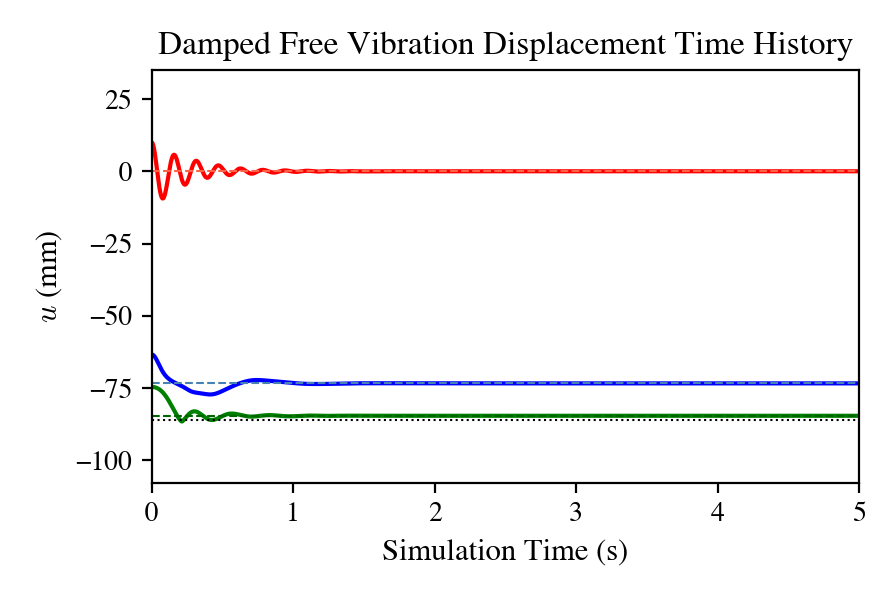

In [75]:
fig = plt.figure(figsize=[4.5,3])
# fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)

outtime = 0.001
ii = 0
for tst in tst_set[:]:
    outfreq = int(outtime/tst['dt'])
    plt.plot(np.arange(tst['nstep'])[::outfreq][:len(tst['history'][0])]*tst['dt'], tst['history'][0]*1000, 
             linestyle=lines[ii], markersize=0.5, linewidth=1.5, c=ccc[ii], label=labelset[ii])
    ii += 1
    
plt.hlines(stable1[0], 0, tst['t'], linestyle='--', color='tomato', linewidth=0.75)
plt.hlines(stable2[0], 0, tst['t'], linestyle='--', color='steelblue', linewidth=0.75)
plt.hlines(stable3[0], 0, tst['t'], linestyle='--', color='darkgreen', linewidth=0.75)
plt.hlines(-0.8*dic['h0'], 0, tst['t'], linestyle=':', color='k', linewidth=0.75)

plt.xlim(0, 5)
plt.ylim(-dic['h0'], 35)
plt.xlabel('Simulation Time (s)', fontsize=11)
plt.ylabel('$u$ (mm)', fontsize=11)
plt.title(f'Damped Free Vibration Displacement Time History', fontsize=12)
plt.tight_layout()
plt.show()

In [73]:
flabel = 14
ftitle = 13
plt.rcParams["font.family"] = "Times"
plt.rcParams['mathtext.fontset'] = 'cm'

<IPython.core.display.Javascript object>


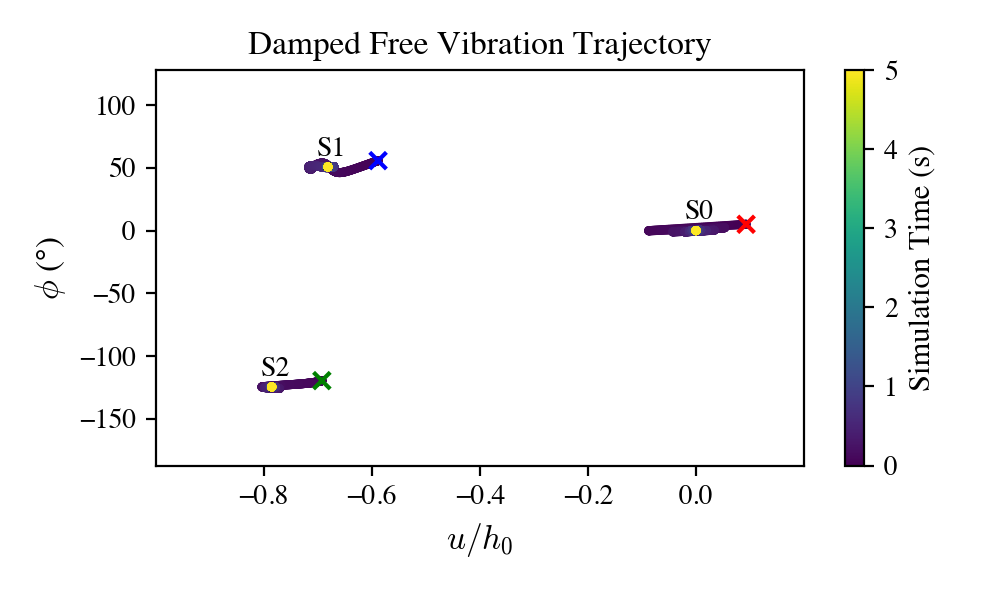

In [74]:
# fig = plt.figure(figsize=[9,3])
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)

# outtime = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
ii = 0
for tst in tst_set:
    disp_hist = tst['history'][0]*1000
    rot_hist = tst['history'][1]/np.pi*180
    sc=  ax.scatter(disp_hist/dic['h0'], rot_hist, s=5.0, alpha=1.0, c=range(len(rot_hist)))
    ii += 1
    
plt.scatter([(stable1[0]+10)/dic['h0'], (stable2[0]+10)/dic['h0'], (stable3[0]+10)/dic['h0']], 
            [stable1[1]/np.pi*180+5, stable2[1]/np.pi*180+5, stable3[1]/np.pi*180+5], 
            marker='x', c=['r', 'b', 'g'])
    
ax.annotate('S0', ((stable1[0])/dic['h0']-0.02, stable1[1]/np.pi*180+9), c='k')
ax.annotate('S1', ((stable2[0])/dic['h0']-0.02, stable2[1]/np.pi*180+9), c='k')
ax.annotate('S2', ((stable3[0])/dic['h0']-0.02, stable3[1]/np.pi*180+9), c='k')

cbar = plt.colorbar(sc)
cbar.set_ticks([0, 1000, 2000, 3000, 4000, 5000])
cbar.ax.set_yticklabels([0, 1, 2, 3, 4, 5], fontsize=10)
cbar.ax.set_ylabel('Simulation Time (s)', fontsize = 11, weight="bold")

plt.xticks([-0.8, -0.6, -0.4, -0.2, 0])
ax.set_title(f'Damped Free Vibration Trajectory', fontsize=ftitle-1)
plt.ylim(dic['phi_min']/np.pi*180, dic['phi_max']/np.pi*180)
plt.xlim(-1.0, 0.2)

ax.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel-2)
ax.set_xlabel('$u/h_0$', fontsize=flabel-2)

plt.tight_layout()
plt.show()